<a href="https://colab.research.google.com/github/blackbaba980/GameOfThronesPredictions/blob/main/code/GameOfThronesPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import from_networkx



import math
import time

import torch

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

random_seed = 7
#set the random seeds 
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

epochs = 200
lr = 0.01
weight_decay = 5e-4
hidden_units = 16
dropout = 0.5

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset Preprocessing


In [2]:
#per season adjaceny matrix, features of every node


def load_data(season_no):

  #read the edge and node files
  dir = "./../data/nodes_edges/"
  edge_file = dir + "got-s" + str(season_no) + "-edges.csv"
  node_file = dir + "got-s" + str(season_no) + "-m-nodes.csv"

  edges = pd.read_csv(edge_file)
  nodes = pd.read_csv(node_file)
  
  
  #only get those edges where the nodes are present
  node_ids = nodes['CHARACTERS ID']
  node_ids_reverse = node_ids.to_dict()
  node_ids = {v: k for k, v in node_ids_reverse.items()}
  
  #remove unnecessary columns
  features = nodes.drop(['CHARACTERS ID'], axis=1)
  features = torch.from_numpy(features.to_numpy().astype(np.float32))
  print("Max feature is {}".format(features.max()))
  edges = edges.drop(['Season'], axis=1)
  print("Max edge is {}".format(edges.max()))
  
  #Adjacency matrix
  gr = nx.Graph()
  adj = np.zeros( (len(node_ids),len(node_ids)) )

  for i in range(len(edges)):
    if edges.iloc[i]['Source'] in node_ids and edges.iloc[i]['Target'] in node_ids:
      src_index = node_ids[edges.iloc[i]['Source']]
      dst_index = node_ids[edges.iloc[i]['Target']]
      gr.add_edge(src_index, dst_index, weight=edges.iloc[i]['Weight'])
      adj[src_index][dst_index] = edges.iloc[i]['Weight']
      adj[dst_index][src_index] = edges.iloc[i]['Weight']


  adj = torch.from_numpy(adj.astype(np.float32))
  print("adj max is {}".format(adj.max()))

  return features, adj, gr, node_ids

  #return torch.from_numpy(features.to_numpy()), torch.from_numpy(adj), gr, node_ids
  #return nodes, edges



#features, adj, graph, node_ids = load_data(1)



# Per Season Graph

In [3]:
per_season_graph = []
per_season_adj = []
per_season_nodes = []
per_season_features = []
per_season_pyg_graph = []
per_season_normalized_adj = []

def normalize_adj(adj):
    return adj / adj.sum()

for i in range(1,9):
    features, adj, graph, node_ids = load_data(i)
    per_season_graph.append(graph)
    per_season_adj.append(adj)
    per_season_nodes.append(node_ids)
    per_season_features.append(features)
    per_season_pyg_graph.append(from_networkx(graph))
    per_season_normalized_adj.append(normalize_adj(adj))
    

Max feature is 1.0
Max edge is Source    WAYMAR_ROYCE
Target           YOREN
Weight             192
dtype: object
adj max is 192.0
Max feature is 1.0
Max edge is Source    TYWIN
Target    YOREN
Weight      177
dtype: object
adj max is 177.0
Max feature is 1.0
Max edge is Source      TYWIN
Target    YGRITTE
Weight        159
dtype: object
adj max is 159.0
Max feature is 1.0
Max edge is Source    VANCE_CORBRAY
Target             ZALA
Weight              162
dtype: object
adj max is 147.0
Max feature is 1.0
Max edge is Source        TYRION
Target    YOHN_ROYCE
Weight           148
dtype: object
adj max is 141.0
Max feature is 1.0
Max edge is Source         VARYS
Target    YOHN_ROYCE
Weight           151
dtype: object
adj max is 151.0
Max feature is 1.0
Max edge is Source         VARYS
Target    YOHN_ROYCE
Weight           179
dtype: object
adj max is 179.0
Max feature is 1.0
Max edge is Source          YARA
Target    YOHN_ROYCE
Weight           194
dtype: object
adj max is 194.0


# Generative Model

In [12]:
class GraphConvolution(Module):
  def __init__(self, in_features, out_features, bias=True):
    super(GraphConvolution, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.weight = Parameter(torch.FloatTensor(in_features, out_features))
    if bias:
        self.bias = Parameter(torch.FloatTensor(out_features))
    else:
        self.register_parameter('bias', None)
    self.reset_parameters()

  def reset_parameters(self):
    stdv = 1. / math.sqrt(self.weight.size(1))
    self.weight.data.uniform_(-stdv, stdv)
    if self.bias is not None:
        self.bias.data.uniform_(-stdv, stdv)

  def forward(self, input, adj):
    support = torch.mm(input, self.weight)
    output = torch.mm(adj, support)
    if self.bias is not None:
        return output + self.bias
    else:
        return output

  def __repr__(self):
    return self.__class__.__name__ + ' (' \
            + str(self.in_features) + ' -> ' \
            + str(self.out_features) + ')'

In [13]:
class Encoder(nn.Module):
  def __init__(self, nfeat, nhid, nclass, dropout):
    super(Encoder, self).__init__()

    self.conv = GraphConvolution(nfeat, nhid)
    self.mean_finder = GraphConvolution(nhid, nclass)
    self.logstd_finder = GraphConvolution(nhid, nclass)    

    
    self.dropout = dropout
    self.embeddings = []

  def forward(self, x, adj, save_embeddings = False):
    x = F.relu(self.conv(x, adj))
    self.mean = self.mean_finder(x, adj)
    self.logstd = self.logstd_finder(x, adj)
    gaussian_noise = torch.randn(x.size(0), 1)
    sampled_z = gaussian_noise*torch.exp(self.logstd) + self.mean
    return sampled_z

  def kl_div(self):
    kl = 0.5/ 42 * (1 + 2*self.logstd - self.mean**2 - torch.exp(self.logstd)**2).sum(1).mean()
    return kl
    

In [14]:
from torch_geometric.nn.models import InnerProductDecoder, VGAE
class Decoder(nn.Module):
  def __init__(self, latent_dim, output_dim):
    super(Decoder, self).__init__()
    #self.decoder = InnerProductDecoder()

    self.linear1 = nn.Linear(42, 42)
    self.linear2 = nn.Linear(42, 42)
    self.linear3 = nn.Linear(42, 42)


    self.ll = nn.ModuleList()

    for i in range(1764):
      self.ll.append(nn.Linear(42, 200))
  

  def forward(self, x):
    x = x.reshape(1,42)
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = F.relu(self.linear3(x))

    outputs = []

    for i in range(1764):
      outputs.append(F.softmax(self.ll[i](x), dim=1))

    #1728 * 200 nodes
    return outputs






In [15]:
from torch_geometric.utils import negative_sampling, remove_self_loops, add_self_loops

class DeepVGAE(nn.Module):
  def __init__(self):
    super(DeepVGAE, self).__init__()
    self.encoder = Encoder(10, 20, 1, dropout)
    self.decoder = Decoder(42,1)


  def forward(self, x, adj):
    z = self.encoder(x, adj)
    self.kl_loss = self.encoder.kl_div()
    adj_pred = self.decoder(z)
    return adj_pred


In [16]:
def find_loss(output, next_season_adj):    
    log_sum = 0
    just_sum = 0

    for i in range(42):
      for j in range(42):
        qx = output[i * 42 + j]
        px_index = int(next_season_adj[i][j].item())
        log_sum += torch.log(qx[0][px_index])
        just_sum += qx[0][px_index]
    return log_sum 


In [17]:
model = DeepVGAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    

In [27]:
#One training step
from tqdm import tqdm


#Give the input graph to the VGAE
overall_loss = []
reconstruction_loss = []
kl_loss = []

EPOCHS = 2

model.train()
for epoch in tqdm(range(EPOCHS)):
    for i in range(6):

        optimizer.zero_grad()
        #Inference
        predicted_adj = model(per_season_features[i], per_season_normalized_adj[i])
        
        
        #find reconstruction loss
        loss = find_loss(predicted_adj, per_season_adj[i+1])
        reconstruction_loss.append(loss.clone().detach().numpy())

        #find kl loss
        kl_divergence = model.kl_loss
        kl_loss.append(kl_divergence.clone().detach().numpy())

        #add recon_loss + kl_loss
        loss -= kl_divergence
        overall_loss.append(loss.clone().detach().numpy())


        loss.backward()
        optimizer.step()


100%|██████████| 2000/2000 [1:31:58<00:00,  2.76s/it]


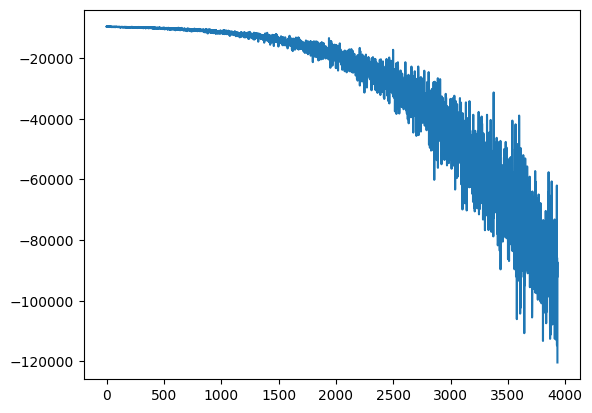

In [28]:
plt.plot(range(EPOCHS * 6), reconstruction_loss)

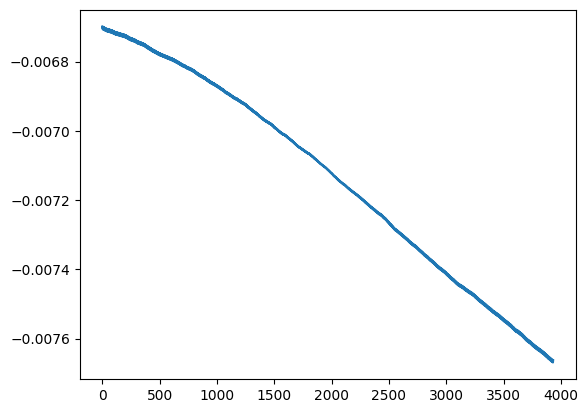

In [29]:
plt.plot(range(EPOCHS * 6), kl_loss)

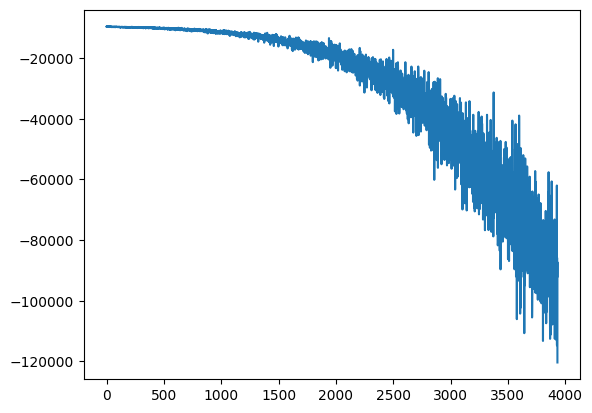

In [30]:
plt.plot(range(EPOCHS * 6), overall_loss)

In [36]:
model.decoder(torch.randn(42, 1))

[tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 

[array(-9657.119, dtype=float32),
 array(-9775.526, dtype=float32),
 array(-9589.34, dtype=float32),
 array(-9659.554, dtype=float32),
 array(-9629.699, dtype=float32),
 array(-9737.788, dtype=float32),
 array(-9683.34, dtype=float32),
 array(-9750.963, dtype=float32),
 array(-9672.8, dtype=float32),
 array(-9697.876, dtype=float32),
 array(-9642.374, dtype=float32),
 array(-9605.865, dtype=float32),
 array(-9695.891, dtype=float32),
 array(-9687.722, dtype=float32),
 array(-9687.329, dtype=float32),
 array(-9612.644, dtype=float32),
 array(-9695.406, dtype=float32),
 array(-9632.325, dtype=float32),
 array(-9726.641, dtype=float32),
 array(-9751.529, dtype=float32),
 array(-9608.354, dtype=float32),
 array(-9679.353, dtype=float32),
 array(-9742.006, dtype=float32),
 array(-9641.246, dtype=float32),
 array(-9770.228, dtype=float32),
 array(-9679.783, dtype=float32),
 array(-9623.52, dtype=float32),
 array(-9711.474, dtype=float32),
 array(-9695.407, dtype=float32),
 array(-9617.414, d